In [1]:
# Imports

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.6.0


In [4]:
dataset_dir = '../dataset'

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
CHANNELS=3
EPOCHS=50

In [6]:
dataset = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                               shuffle = True,
                                                               batch_size = BATCH_SIZE,
                                                               image_size = IMAGE_SIZE)

Found 4000 files belonging to 4 classes.


In [7]:
# Exploring the dataset

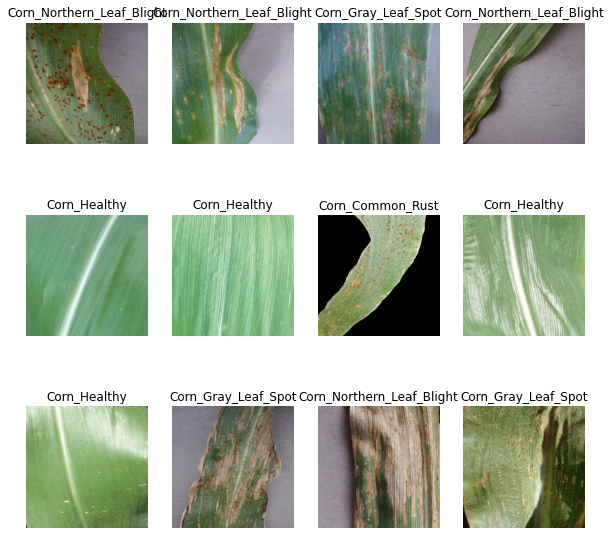

In [8]:
class_names = dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):
    
  for i in range(12):
    
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
print("Length of dataset is {}. Remember that batch size of images is 32. Total of images is 4000 = 125 x 32.".format(len(dataset)))

Length of dataset is 125. Remember that batch size of images is 32. Total of images is 4000 = 125 x 32.


In [10]:
# Training Dataset, Validation Dataset and Test Dataset

In [11]:
total_dataset_len = len(dataset)

In [12]:
# 80 % Training Dataset
# 20 % Validation Dataset & Test Dataset

In [13]:
training_dataset_len = int(total_dataset_len * 0.8)

training_dataset = dataset.take(training_dataset_len)
print(training_dataset_len)

100


In [14]:
# To be used for Validation & Testing
rest_of_dataset = dataset.skip(training_dataset_len)
rest_of_dataset_len = len(rest_of_dataset) 
print(rest_of_dataset_len)

25


In [15]:
validation_dataset_len = int(rest_of_dataset_len * 0.5)
validation_dataset = rest_of_dataset.take(validation_dataset_len)
validation_dataset_len

12

In [16]:
test_dataset = rest_of_dataset.skip(validation_dataset_len)
print(len(test_dataset))

13


In [17]:
# Cache, Shuffle, and Prefetch the Dataset